## Install Dependencies and Import Libraries

In [15]:
# Python version must be 3.6 ~ 3.10, which is officially supported for pyrealsense2 library
!pip install -r requirements.txt

In [18]:
!pip install albumentations

In [ ]:
import pyrealsense2 as rs
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from ultralytics import YOLO
from datetime import datetime
import json
import shutil
import random
from pathlib import Path

ModuleNotFoundError: No module named 'albumentations'

In [3]:
IMAGE_CAPTURE_D435I_PATH = "captured_images/D435i/"

## Dataset Preprocessing

In [ ]:
# Paths
original_image_dir = Path("dataset/images")
labelme_dir = Path("dataset/annotations")
output_base = Path("yolo_dataset")
output_images = output_base / "images"
output_masks = output_base / "masks"
output_labels = output_base / "labels"

splits = ['train', 'val']
split_ratio = 0.2  # 80/20 train/val split

# Create folders
for split in splits:
    for t in ['images', 'labels', 'masks']:
        os.makedirs(output_base / t / split, exist_ok=True)

# Extract unique class labels
def extract_labels(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return list(set(shape['label'] for shape in data['shapes']))

# Convert Labelme JSON → YOLOv8-compatible masks + labels
def convert_labelme_to_yolo(json_file, save_prefix, class_map):
    with open(json_file) as f:
        data = json.load(f)

    image_path = original_image_dir / data["imagePath"]
    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]

    label_lines = []

    for i, shape in enumerate(data["shapes"]):
        label = shape["label"]
        cls_id = class_map[label]
        mask = np.zeros((h, w), dtype=np.uint8)
        points = np.array([shape["points"]], dtype=np.int32)
        cv2.fillPoly(mask, points, 255)

        mask_filename = f"{save_prefix}_{cls_id}_{i}.png"
        cv2.imwrite(str(output_base / "masks" / mask_filename), mask)

        label_lines.append(f"{cls_id} masks/{mask_filename}")

    # Save YOLOv8 .txt file
    with open(output_base / "labels" / f"{save_prefix}.txt", "w") as f:
        f.write("\n".join(label_lines))

    # Copy image
    shutil.copy(image_path, output_base / "images" / f"{save_prefix}.png")

# MAIN
json_files = list(labelme_dir.glob("*.json"))
random.shuffle(json_files)

# Create class map
all_labels = sorted(set(label for jf in json_files for label in extract_labels(jf)))
class_map = {label: i for i, label in enumerate(all_labels)}

# Train/test split
train_files, val_files = train_test_split(json_files, test_size=split_ratio)

# Convert files
for split, files in zip(splits, [train_files, val_files]):
    for json_file in files:
        name = json_file.stem
        convert_labelme_to_yolo(json_file, save_prefix=name, class_map=class_map)
        # Move files to split folders
        for t in ['images', 'labels']:
            src = output_base / t / f"{name}.png" if t == 'images' else output_base / t / f"{name}.txt"
            dst = output_base / t / split / src.name
            shutil.move(src, dst)

# Save data.yaml
yaml_content = f"""
path: {output_base}
train: images/train
val: images/val
names: {all_labels}
"""

with open(output_base / "data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ Preprocessing complete. Dataset is ready.")


## YOLOv8 Seg Model Training

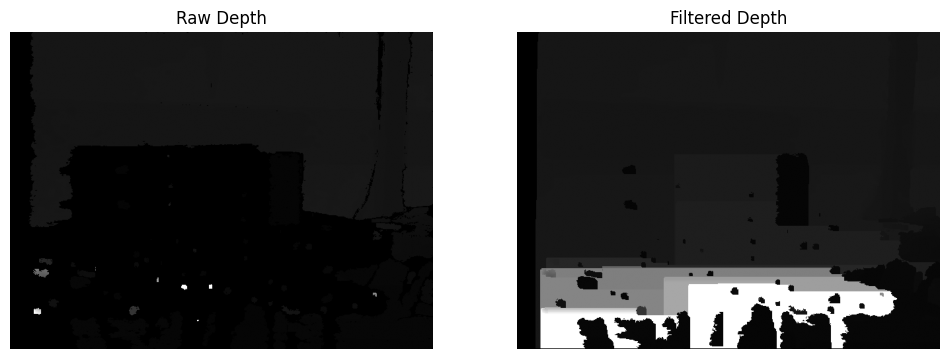

In [ ]:
import os
import json
import shutil
import random
import cv2
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split

# Required: pip install ultralytics opencv-python labelme

# Paths
original_image_dir = Path("dataset/images")
labelme_dir = Path("dataset/annotations")  # contains JSONs
output_base = Path("yolo_dataset")
output_images = output_base / "images"
output_masks = output_base / "masks"
output_labels = output_base / "labels"

# YOLO splits
splits = ['train', 'val']
split_ratio = 0.2  # 80% train, 20% val

# Create folders
for split in splits:
    for t in ['images', 'labels', 'masks']:
        os.makedirs(output_base / t / split, exist_ok=True)

# Extract label names from JSON files
def extract_labels(json_path):
    with open(json_path) as f:
        data = json.load(f)
    return list(set(shape['label'] for shape in data['shapes']))

# Convert Labelme JSON to YOLOv8-seg format (mask per instance)
def convert_labelme_to_yolo(json_file, save_prefix, class_map):
    with open(json_file) as f:
        data = json.load(f)

    image_path = original_image_dir / data["imagePath"]
    image = cv2.imread(str(image_path))
    h, w = image.shape[:2]

    mask_output = np.zeros((h, w), dtype=np.uint8)
    label_lines = []

    for shape in data["shapes"]:
        label = shape["label"]
        cls_id = class_map[label]
        mask = np.zeros((h, w), dtype=np.uint8)
        points = np.array([shape["points"]], dtype=np.int32)
        cv2.fillPoly(mask, points, 255)

        # Save binary mask per shape (YOLOv8-style)
        mask_filename = f"{save_prefix}_{cls_id}.png"
        cv2.imwrite(str(output_base / "masks" / mask_filename), mask)

        # Relative path to mask image
        label_lines.append(f"{cls_id} masks/{mask_filename}")

    # Save YOLO .txt label file
    with open(output_base / "labels" / f"{save_prefix}.txt", "w") as f:
        f.write("\n".join(label_lines))

    # Copy image
    shutil.copy(image_path, output_base / "images" / f"{save_prefix}.png")

# Main: Split and convert
json_files = list(labelme_dir.glob("*.json"))
random.shuffle(json_files)

# Extract all class labels
all_labels = sorted(set(label for jf in json_files for label in extract_labels(jf)))
class_map = {label: i for i, label in enumerate(all_labels)}

# Train/test split
train_files, val_files = train_test_split(json_files, test_size=split_ratio)

for split, files in zip(splits, [train_files, val_files]):
    for json_file in files:
        name = json_file.stem
        convert_labelme_to_yolo(
            json_file=json_file,
            save_prefix=name,
            class_map=class_map,
        )
        # Move to split folders
        for t in ['images', 'labels']:
            src = output_base / t / f"{name}.png" if t == 'images' else output_base / t / f"{name}.txt"
            dst = output_base / t / split / src.name
            shutil.move(src, dst)

# Save data.yaml
yaml_content = f"""
path: {output_base}
train: images/train
val: images/val
names: {all_labels}
"""

with open(output_base / "data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ Dataset ready. Starting training...")

# Train YOLOv8 segmentation model
from ultralytics import YOLO
model = YOLO('yolov8n-seg.pt')  # or yolov8m-seg.pt etc.

model.train(
    data=str(output_base / "data.yaml"),
    epochs=50,
    imgsz=512,
    batch=8,
    project="yolo_seg_project",
    name="yolov8-seg-train"
)


## Test Image Enhancement for Contour Emphasis

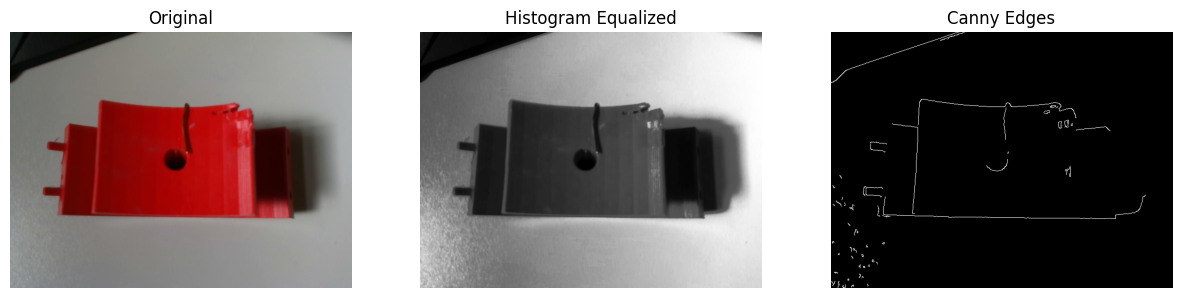

In [10]:
# Load an image
image = cv2.imread("testimage_1.png", cv2.IMREAD_COLOR)
# image = cv2.imread("testimage_2.png", cv2.IMREAD_COLOR)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Histogram equalization
equalized = cv2.equalizeHist(gray)

# Convert back to BGR for display
equalized_bgr = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)

# Edge detection
edges = cv2.Canny(equalized, 100, 200)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(equalized_bgr, cv2.COLOR_BGR2RGB))
axs[1].set_title("Histogram Equalized")
axs[1].axis('off')

axs[2].imshow(edges, cmap='gray')
axs[2].set_title("Canny Edges")
axs[2].axis('off')

plt.show()

## Test YOLOv8 Segmentation


0: 480x640 1 umbrella, 1 toothbrush, 110.2ms
Speed: 2.5ms preprocess, 110.2ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


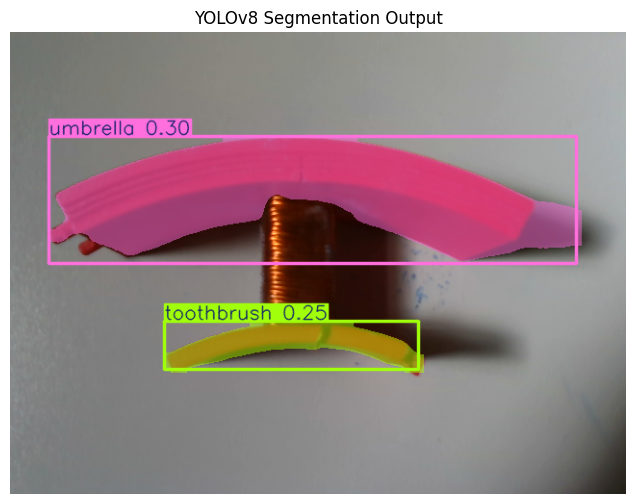

In [15]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load model and image
model = YOLO("yolov8s-seg.pt")  # Load pretrained model
# image = cv2.imread("testImage_1.png")
image = cv2.imread("testImage_2.png")

# Run inference
results = model(image)[0]

# Draw results
segmented = results.plot()

# Show
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
plt.title("YOLOv8 Segmentation Output")
plt.axis('off')
plt.show()


In [ ]:
import cv2
import numpy as np

# Load image
image = cv2.imread("testImage_2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Threshold to binary
_, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Morphological cleanup
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Distance transform (foreground)
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
watershed_image = image.copy()
markers = cv2.watershed(watershed_image, markers)
watershed_image[markers == -1] = [0, 0, 255]  # Mark boundary in red

# Display result
cv2.imshow("Watershed Segmentation", watershed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Load image
image = cv2.imread("testImage_2.png")
Z = image.reshape((-1, 3))
Z = np.float32(Z)

# K-means parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # Number of clusters (tune this)
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented = centers[labels.flatten()].reshape(image.shape)

# Convert to grayscale for edge detection
gray = cv2.cvtColor(segmented, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150)

# Overlay edges on original
overlay = image.copy()
overlay[edges != 0] = [0, 0, 255]  # Red edges

# Display
cv2.imshow("K-means + Edge Overlay", overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Intel D435i Streaming and Image Capture Code

In [8]:
# Create output folder
output_folder = IMAGE_CAPTURE_D435I_PATH + "raw_images/"
os.makedirs(output_folder, exist_ok=True)

# Find next available image number
existing_files = glob.glob(os.path.join(output_folder, "imgCapture_*_color.png"))
existing_ids = [
    int(os.path.basename(f).split("_")[1]) 
    for f in existing_files 
    if os.path.basename(f).split("_")[1].isdigit()
]
img_counter = max(existing_ids) + 1 if existing_ids else 1

# Initialize RealSense pipeline
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
pipeline.start(config)

print("Press SPACEBAR to capture RGB + Depth. Press ESC to exit.")

try:
    while True:
        # Wait for frames
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if not color_frame or not depth_frame:
            continue

        # Convert to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())

        # Convert depth to colormap for visualization
        depth_colormap = cv2.applyColorMap(
            cv2.convertScaleAbs(depth_image, alpha=0.03),
            cv2.COLORMAP_JET
        )

        # Display combined image
        combined = np.hstack((color_image, depth_colormap))
        cv2.imshow("RealSense - SPACE to Capture | ESC to Exit", combined)

        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # ESC
            print("Exiting...")
            break
        elif key == 32:  # SPACEBAR
            # Define filenames
            base_name = f"imgCapture_{img_counter}"
            rgb_path = os.path.join(output_folder, f"{base_name}_color.png")
            depth_raw_path = os.path.join(output_folder, f"{base_name}_depth.png")
            depth_colormap_path = os.path.join(output_folder, f"{base_name}_depth_colormap.png")

            # Save images
            cv2.imwrite(rgb_path, color_image)
            cv2.imwrite(depth_raw_path, depth_image)  # 16-bit raw depth
            cv2.imwrite(depth_colormap_path, depth_colormap)

            print(f"Captured: {rgb_path}, {depth_raw_path}, {depth_colormap_path}")
            img_counter += 1

finally:
    pipeline.stop()
    cv2.destroyAllWindows()

Press SPACEBAR to capture RGB + Depth. Press ESC to exit.
Captured: captured_images/D435i/raw_images/imgCapture_3_color.png, captured_images/D435i/raw_images/imgCapture_3_depth.png, captured_images/D435i/raw_images/imgCapture_3_depth_colormap.png
Exiting...


## Real-Time Canny Edge Detection using Intel D435i

In [ ]:
# Create output folder
output_folder = IMAGE_CAPTURE_D435I_PATH + "cannyEdge/"
os.makedirs(output_folder, exist_ok=True)

# Find next available image number
existing_files = glob.glob(os.path.join(output_folder, "imgCapture_*_color.png"))
existing_ids = [
    int(os.path.basename(f).split("_")[1]) 
    for f in existing_files 
    if os.path.basename(f).split("_")[1].isdigit()
]
img_counter = max(existing_ids) + 1 if existing_ids else 1

# Initialize pipeline and configure streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
pipeline.start(config)

print("Press SPACEBAR to capture image. Press ESC to exit.")

try:
    while True:
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()

        if not color_frame or not depth_frame:
            continue

        # Convert frames to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())

        # --- RGB Edge Detection ---
        gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        # gray_blur = cv2.GaussianBlur(gray, (5, 5), 1.4)
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # gray_eq = clahe.apply(gray_blur)
        # edges_rgb = cv2.Canny(gray_eq, 50, 150)
        gray_blur = cv2.GaussianBlur(gray, (3, 3), 0.8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_eq = clahe.apply(gray_blur)
        edges_rgb = cv2.Canny(gray_eq, 30, 100)

        # --- Depth Edge Detection ---
        depth_8u = cv2.convertScaleAbs(depth_image, alpha=0.03)
        # depth_blur = cv2.GaussianBlur(depth_8u, (5, 5), 1.4)
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # depth_eq = clahe.apply(depth_blur)
        # edges_depth = cv2.Canny(depth_eq, 50, 150)
        depth_blur = cv2.GaussianBlur(depth_8u, (3, 3), 0.8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        depth_eq = clahe.apply(depth_blur)
        edges_depth = cv2.Canny(depth_eq, 30, 100)

        # Stack edges for display
        combined = np.hstack((edges_rgb, edges_depth))
        cv2.imshow("Canny Edges | RGB (left) vs Depth (right)", combined)

        key = cv2.waitKey(1) & 0xFF

        if key == 27:  # ESC
            print("Exiting...")
            break

        elif key == 32:  # SPACEBAR
            base_name = f"imgCapture_{img_counter}"
            cv2.imwrite(os.path.join(output_folder, f"{base_name}_color.png"), color_image)
            cv2.imwrite(os.path.join(output_folder, f"{base_name}_depth.png"), depth_image)
            cv2.imwrite(os.path.join(output_folder, f"{base_name}_edges_rgb.png"), edges_rgb)
            cv2.imwrite(os.path.join(output_folder, f"{base_name}_edges_depth.png"), edges_depth)

            print(f"Captured: {base_name}_*.png")
            img_counter += 1

finally:
    pipeline.stop()
    cv2.destroyAllWindows()

Press SPACEBAR to capture image. Press ESC to exit.
Captured: imgCapture_1_*.png
Captured: imgCapture_2_*.png
Exiting...


Video Capture Code

In [12]:
# === Output folder setup ===
output_folder = IMAGE_CAPTURE_D435I_PATH + "cannyEdge/"
os.makedirs(output_folder, exist_ok=True)

# === RealSense stream setup ===
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
pipeline.start(config)

# === Video writer variables ===
recording = False
video_writer = None
fourcc = cv2.VideoWriter_fourcc(*'MP4V')  # Use 'MP4V' for .mp4 output

print("Press SPACEBAR to START/STOP recording. ESC to exit.")

try:
    while True:
        # Capture frames
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()
        if not color_frame or not depth_frame:
            continue

        # Convert to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        depth_image = np.asanyarray(depth_frame.get_data())

        # === Edge Detection on RGB ===
        gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        gray_blur = cv2.GaussianBlur(gray, (3, 3), 0.8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray_eq = clahe.apply(gray_blur)
        edges_rgb = cv2.Canny(gray_eq, 30, 100)

        # Convert edge map to 3-channel
        edges_rgb_bgr = cv2.cvtColor(edges_rgb, cv2.COLOR_GRAY2BGR)

        # Combine original RGB and edge map side-by-side
        combined = np.hstack((color_image, edges_rgb_bgr))

        # Display the live output
        cv2.imshow("RGB + Canny Edge View", combined)

        # Save video if recording
        if recording and video_writer is not None:
            video_writer.write(combined)

        # Keypress controls
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC = exit
            break
        elif key == 32:  # SPACEBAR = toggle recording
            recording = not recording
            if recording:
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                filename = os.path.join(output_folder, f"videoCapture_{timestamp}.avi")
                video_writer = cv2.VideoWriter(filename, fourcc, 30.0, (combined.shape[1], combined.shape[0]))
                print(f"[Recording started] -> {filename}")
            else:
                video_writer.release()
                video_writer = None
                print("[Recording stopped]")

finally:
    if video_writer is not None:
        video_writer.release()
    pipeline.stop()
    cv2.destroyAllWindows()

Press SPACEBAR to START/STOP recording. ESC to exit.
[Recording started] -> captured_images/D435i/cannyEdge/videoCapture_20250513_135850.avi


## Real-Time Object Segmentation using Intel D435i

In [40]:
# === Output folder setup ===
output_folder = IMAGE_CAPTURE_D435I_PATH + "segment_colThresh/"
os.makedirs(output_folder, exist_ok=True)

existing_files = glob.glob(os.path.join(output_folder, "threshCapture_*.png"))
existing_ids = [
    int(os.path.basename(f).split("_")[1].split(".")[0])
    for f in existing_files
    if os.path.basename(f).split("_")[1].split(".")[0].isdigit()
]
img_counter = max(existing_ids) + 1 if existing_ids else 1

# === RealSense Setup ===
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipeline.start(config)

print("Running threshold-based segmentation... Press SPACEBAR to save annotated image, ESC to exit.")

try:
    while True:
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        if not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
        gray = clahe.apply(gray)

        # === Adaptive Thresholding to handle light/dark backgrounds ===
        thresh = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV, 35, 3
        )

        # === Morphological cleaning ===
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

        # === Find largest contour ===
        contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        output = color_image.copy()
        if contours:
            largest = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest)
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(output, "Threshold-Segmented Object", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # === Show both original and threshold views ===
        clean_bgr = cv2.cvtColor(clean, cv2.COLOR_GRAY2BGR)
        stacked = np.hstack((output, clean_bgr))
        cv2.imshow("Threshold Segmentation | RGB (left) + Binary Mask (right)", stacked)

        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break
        elif key == 32 and contours:
            filename = os.path.join(output_folder, f"threshCapture_{img_counter}.png")
            cv2.imwrite(filename, output)
            print(f"Saved segmented image: {filename}")
            img_counter += 1

finally:
    pipeline.stop()
    cv2.destroyAllWindows()

Running threshold-based segmentation... Press SPACEBAR to save annotated image, ESC to exit.
Saved segmented image: captured_images/D435i/segment_colThresh/threshCapture_5.png
Saved segmented image: captured_images/D435i/segment_colThresh/threshCapture_6.png


## Fracture Identification Code Trial

In [43]:
# === Output folder setup ===
output_folder = IMAGE_CAPTURE_D435I_PATH + "captured_fractures/"
os.makedirs(output_folder, exist_ok=True)

existing_files = glob.glob(os.path.join(output_folder, "fractureCapture_*.png"))
existing_ids = [
    int(os.path.basename(f).split("_")[1].split(".")[0])
    for f in existing_files
    if os.path.basename(f).split("_")[1].split(".")[0].isdigit()
]
img_counter = max(existing_ids) + 1 if existing_ids else 1

# === RealSense Setup ===
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
pipeline.start(config)

print("Running segmentation + fracture detection... SPACEBAR = save fractures only | ESC = exit.")

# === Fracture Detection ===
def detect_fractures(gray_img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray_eq = clahe.apply(gray_img)
    _, thresh = cv2.threshold(gray_eq, 85, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    fractures = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 65 < area < 1000:
            x, y, w, h = cv2.boundingRect(cnt)
            fractures.append((x, y, w, h))
    return fractures

try:
    while True:
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        if not color_frame:
            continue

        color_image = np.asanyarray(color_frame.get_data())
        gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

        # === Segmentation (optional preprocessing) ===
        clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
        gray_eq = clahe.apply(gray)

        thresh = cv2.adaptiveThreshold(
            gray_eq, 255,
            cv2.ADAPTIVE_THRESH_MEAN_C,
            cv2.THRESH_BINARY_INV, 35, 3
        )
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

        contours, _ = cv2.findContours(clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        roi_gray = None
        offset = (0, 0)

        # === Segmentation Block ===
        if contours:
            largest = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest)
            roi_gray = gray_eq[y:y+h, x:x+w]
            offset = (x, y)

        # === Fallback if no object detected ===
        if roi_gray is None:
            roi_gray = gray_eq
            offset = (0, 0)

        # === Fracture detection only ===
        fracture_image = color_image.copy()
        fractures = detect_fractures(roi_gray)
        for (fx, fy, fw, fh) in fractures:
            cv2.rectangle(fracture_image, (offset[0] + fx, offset[1] + fy),
                          (offset[0] + fx + fw, offset[1] + fy + fh), (0, 0, 255), 2)
            cv2.putText(fracture_image, "Fracture", (offset[0] + fx, offset[1] + fy - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

        # === Display fracture detection live ===
        cv2.imshow("Fracture Detection Only", fracture_image)

        key = cv2.waitKey(1) & 0xFF
        if key == 27:
            break
        elif key == 32:
            filename = os.path.join(output_folder, f"fractureCapture_{img_counter}.png")
            cv2.imwrite(filename, fracture_image)
            print(f"Saved fracture image: {filename}")
            img_counter += 1

finally:
    pipeline.stop()
    cv2.destroyAllWindows()

Running segmentation + fracture detection... SPACEBAR = save fractures only | ESC = exit.
